# Initialization

In [6]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import darkchem

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

%%matplotlib inline

UsageError: Line magic function `%%matplotlib` not found.


# Chemical Reactions

## Goal

Our goal is to **determine how chemical reactions can be encoded in DarkChem's latent space**. In order to do this, we have selected a few simple chemical reactions, investigated how some test reactants and products are separately encoded in the latent space, and compare the difference vector (i.e. "reaction vector") across each reaction in order to determine whether a generalized reaction model exists.

Mathematically speaking, we can represent our process in the latent space as:

$\Big( \overrightarrow{product_{1}} - \overrightarrow{reactant_{1}} \Big) = \overrightarrow{reaction} \stackrel{?}{=} \Big( \overrightarrow{product_{2}} - \overrightarrow{reactant_{2}} \Big)$

Note that generally, reaction stoichiometry was ignored for initial exploration purposes.

## Enolate Alkylation (CC Bond Formation)

Alkylation (in this case, methylation) was explored through the following reactions.

1. $CH_{3}C(O)CH_{3} + OH^{-} + CH_{3}Br \rightarrow CH_{3}C(O)CH_{2}CH_{3} + H_{2}O + Br^{-}$
2. Cyclohexanone $\rightarrow$ 2-methylcyclohexanone
3. 2-Methylcyclopentanone $\rightarrow$ 2,2-dimethylcyclopentanone
4. 2-Methylcyclopentanone $\rightarrow$ 2,5-dimethylcyclopentanone

Note that (4) is the kinetic product more readily accessed from the same starting material.

In [1]:
# Canonical SMILES strings accessed from OpenBabel
smilescc = {'reactants': ['CC(=O)C', 'O=C1CCCCC1', 'O=C1CCCC1C', 'O=C1CCCC1C'], 
             'products': ['CCC(=O)C', 'CC1CCCCC1=O', 'CC1CCC(C1=O)C', 'O=C1CCCC1(C)C']}

In [4]:
# Conversion to DarkChem latent space vectors
smilescc['rvec'] = [darkchem.utils.struct2vec(reactant).astype(np.int16) for reactant in smilescc['reactants']]
smilescc['pvec'] = [darkchem.utils.struct2vec(product).astype(np.int16) for product in smilescc['products']]
smilescc['rxnvector'] = [smilescc['pvec'][i] - smilescc['rvec'][i] for i in range(len(smilescc))]

As a metric of how similar the reaction vectors are to one another for the same type of reaction, **Pearson correlation coefficients** were calculated between each of the reaction vectors.  Pearson correlation coefficients are a measure of linear correlation between two variables and are a quick way to assess whether the reaction vectors are similar (at least in terms of their directional interpretation.

In [5]:
# Calculation of Pearson correlation coefficients between the different reaction vectors
np.corrcoef(smilescc['rxnvector'])

array([[ 1.        , -0.00168265,  0.06415584, -0.01032847],
       [-0.00168265,  1.        ,  0.71701091,  0.34875671],
       [ 0.06415584,  0.71701091,  1.        ,  0.78291073],
       [-0.01032847,  0.34875671,  0.78291073,  1.        ]])

In [ ]:
# Conversion to dataframe
#smilesdf = pd.DataFrame(smiles)
#smilesdf.head()

**Conclusions:**

* The correlation coefficients between the reaction vectors ranges widely.
* This is a complex reaction type involving several reagents not accounted for, perhaps explaining the lack of correlation.

## Activation of Benzene

Ring substitution reactions were explored on benzene with the following:

1. $C_{6}H_{6} + TMEDA +  nBuLi + SO_{2} \rightarrow C_{6}H_{5}S(O)OH$
2. $C_{6}H_{6} + cat. \rightarrow C_{6}H_{5}NO_{2}$
3. $C_{6}H_{6} + H_{2} + cat. \rightarrow C_{6}H_{12}$
4. Benzene $\rightarrow$ Acetophenone

In [9]:
# Load reactants
smi_in_b = {'reactants': ['c1ccccc1','c1ccccc1','c1ccccc1','c1ccccc1']}
# Load products  
smi_out_b = {'products':['OS(c1ccccc1)(O)O','ON(c1ccccc1)O','Cc1ccccc1','CC(=O)c1ccccc1']}  
# Transform to DataFrame
smi_in_b = pd.DataFrame(smi_in_b)  
smi_out_b = pd.DataFrame(smi_out_b)
# Represent reactants in the form of vector
rct_b = [darkchem.utils.struct2vec(smi) for smi in smi_in_b['reactants']]  
# Represent prodcuts in the form of vector
prod_b = [darkchem.utils.struct2vec(smi) for smi in smi_out_b['products']] 

In [10]:
# Put those vectors into DataFrame
rct_b = pd.DataFrame(rct_b)
prod_b = pd.DataFrame(prod_b)

In [11]:
# Calculate the lengh of each reaction path
s = 0
d = []
for i in range(4):
    for j in range(100):
        s += (rct_b.loc[i][j] - prod_b.loc[i][j])**2
    ds = np.sqrt(s)
    d.append(ds)
print('The length of each reaction path =', d)

The length of each reaction path = [52.706735812417755, 65.43699259593154, 67.72739475278819, 76.8830280361017]


In [13]:
# Calculate the dot product of each reaction
s2 = 0
d2= []
for i in range(4):
    for j in range(100):
        s2 += (rct_b.loc[i][j] * prod_b.loc[i][j])
    #ds = np.sqrt(s)
    d2.append(s2)

In [14]:
# Calculate the product of each reactant and product
s3 = 0
s4 = 0
d3= []
for i in range(4):
    for j in range(100):
        s3 += (rct_b.loc[i][j])**2
        s4 += (prod_b.loc[i][j])**2
    dd = np.sqrt(s3)
    dx = np.sqrt(s4)
    xx = dd*dx
    d3.append(xx)

In [15]:
# Insert the formula of Cosine theorem
a = []
for i in range(4):
    cos = d2[i]/d3[i]  #this is the value of cos(theta)
    angle = math.acos(cos)  #this is the value of theta
    a.append(angle)
print('The angle between the vectors of reactants and products of each reactions =')
print(a)

The angle between the vectors of reactants and products of each reactions =
[1.052329946187754, 0.9951601656470028, 0.9469617135923684, 0.8613795706871101]


## Chemical Reduction

The same process was repeated for chemical reduction and hydration (+OH) reactions:

#### Reduction
| Index |Benzene |1-Butene|2-Butene|1-Hexene|
|-------|--------|--------|--------|--------|
| Length| 4.89897|21.18962|37.94733|43.18564|
| Angle |0.008055|0.462757|0.590913|0.557938|

#### Hydration
| Index |Benzene |1-Butene|2-Butene|1-Hexene|
|-------|--------|--------|--------|--------|
| Length|18.05547|32.43454|34.20526|43.54308|
| Angle |0.611504|0.645730|0.509857|0.540477|

## Chemical Oxidation

Chemical oxidation was explored through the following reactions:

1. $H_{2} + O_{2} \rightarrow H_{2}O$
2. $S + O_{2} \rightarrow SO_{2}$
3. $C + O_{2} \rightarrow CO_{2}$
4. $N_{2} + O_{2} \rightarrow NO$
5. $NO + O_{2} \rightarrow NO_{2}$

### Calculation of Reaction Vectors

In [16]:
smi_in = {'reactants':['[H][H].O=O','[S].O=O','[C].O=O','N#N.O=O','[N]=O.O=O']}  # load reactants
smi_out = {'products':['O','O=S=O','C(=O)=O','[N]=O','N(=O)[O]']}      # load products   
smi_in = pd.DataFrame(smi_in)                                          # transform to dataframe
smi_out = pd.DataFrame(smi_out)                                        # transform to dataframe

In [17]:
rct = [darkchem.utils.struct2vec(smi) for smi in smi_in['reactants']]  # vectorize reactants in DC latent space 
prod = [darkchem.utils.struct2vec(smi) for smi in smi_out['products']] # vectorize products in DC latent space
rct_df = pd.DataFrame(data = rct) # transform np.array to DataFrame
prod_df = pd.DataFrame(data = prod) # transform np.array to DataFrame

In [ ]:
# Uncomment to preview dataframes
#rct_df_ox.head()
#prod_df_ox.head()

In [18]:
x = rct_df.iloc[:,0:100].values
y = prod_df.iloc[:,0:100].values

### Prediction

A regression model was applied to see if prediction of reaction products is possible.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = .2, random_state=1234)

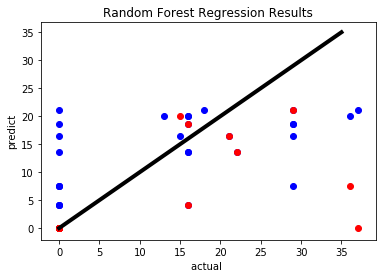

In [20]:
# Fitting the Regression model to the dataset

from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 300, random_state = 123, min_samples_split=15)
regressor.fit(X_train,y_train)

# Predicting a new result with the Random Forest Regression

Ytrain_Pred = regressor.predict(X_train)
Ytest_Pred = regressor.predict(X_test)

# Visualising the Random Forest Regression results in higher resolution and smoother curve
#X_Grid = np.arange(min(X), max(X), 0.01)
#X_Grid = X_Grid.reshape((len(X_Grid), 1))
plt.scatter(y_train,Ytrain_Pred, color = 'blue')
plt.scatter(y_test,Ytest_Pred, color = 'red')
#plt.plot(X_Grid, regressor.predict(X_Grid), color = 'black')
plt.plot([0,35],[0,35],lw=4,color='black')
plt.title('Random Forest Regression Results')
plt.xlabel('actual ')
plt.ylabel('predict')
plt.show()

In [21]:
regressor.score(X_test,y_test)  # the correlation value  

0.0

In [22]:
CO = darkchem.utils.struct2vec('[C-]#[O+]')  # transform to vect   CO carbon monoxide

In [23]:
CO_test = regressor.predict(CO.reshape(1,-1)) # test the prediction function   prediction

In [24]:
CO_test

array([[20.05833333, 16.445     , 21.02333333, 18.53666667, 13.63      ,
         7.49166667,  4.13333333,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

In [25]:
rou = [20,16,21,19,14,8,4] # round the data
for i in range(100):
    if (i < 7) :
        CO_test[0][i] = rou[i]
CO_test

array([[20., 16., 21., 19., 14.,  8.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [26]:
c = CO_test.flatten() # remove brackets
test = c.astype(int) # transform the data type to int

In [27]:
darkchem.utils.vec2struct(test) # prediction result of CO oxidation reaction

'-O(/H84'

In [28]:
# calculate the distance between the reactants and products
s = 0
d = []
for i in range(rct_df.shape[0]):
    for j in range(rct_df.shape[1]):
        s += (rct_df.loc[i][j] - prod_df.loc[i][j])**2
    ds = np.sqrt(s)
    d.append(ds)
print(d)

[83.4445923951936, 94.56743625582752, 98.89388252060893, 109.67223896684156, 114.70832576583096]


In [29]:
#calculate the product of vectors(p vector * r vector)
s2 = 0
d2= []
for i in range(5):
    for j in range(100):
        s2 += (rct_df.loc[i][j] * prod_df.loc[i][j])
    #ds = np.sqrt(s)
    d2.append(s2)
print(d2)

[576, 3408, 7119, 9732, 14813]


In [30]:
# calculate the product of |p| * |r|
s3 = 0
s4 = 0
d3= []
for i in range(5):
    for j in range(100):
        s3 += (rct_df.loc[i][j])**2  # the square length of reactant vector
        s4 += (prod_df.loc[i][j])**2 # the square lenght of product vector
    dd = np.sqrt(s3) # the length of reactant vector
    dx = np.sqrt(s4) # the lenght of product vector
    xx = dd*dx # the product of |p| * |r|
    d3.append(xx)
print(d3)

[1418.4160179580601, 6001.698926137498, 10433.085449664448, 14679.26111900732, 20481.382741406887]


In [31]:
# calculate the cos(theta) value of reactant vector and product vector
a = []
for i in range(5):
    cos = d2[i]/d3[i]  #this is the value of cos(theta)
    a.append(cos)
print(a)

[0.40608678462980474, 0.5678392138529481, 0.6823484801640308, 0.6629761485337025, 0.7232421847208974]


In [32]:
# result of oxidation reactions
result = {'distance':d, 'cos(theta)':a}
result = pd.DataFrame(result, index = ['H2','S','C','N2','NO'])  
result

,distance,cos(theta)
H2,83.444592,0.406087
S,94.567436,0.567839
C,98.893883,0.682348
N2,109.672239,0.662976
NO,114.708326,0.723242


In [33]:
# calculate the vector of the reaction path 
oxi_rec = pd.DataFrame()
for i in range(5):
    for j in range(100):
        oxi_rec.loc[i,j] =  prod_df.loc[i][j] - rct_df.loc[i][j]
oxi_rec

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-20.0,-14.0,-37.0,-36.0,-14.0,-37.0,-28.0,-16.0,-29.0,-16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-20.0,11.0,-19.0,1.0,0.0,-29.0,-16.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-23.0,8.0,-8.0,-12.0,6.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,21.0,-15.0,22.0,1.0,0.0,-29.0,-16.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-21.0,6.0,-8.0,-13.0,6.0,8.0,0.0,8.0,-16.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
# oxidation path vector correlation
cor = pd.DataFrame()
for i in range(5):
    for j in range(5):
        cor.loc[i,j] = oxi_rec.iloc[i].corr(oxi_rec.iloc[j])  # for all reactions
cor

,0,1,2,3,4
0,1.000000,0.644632,0.401150,0.111594,0.367941
1,0.644632,1.000000,0.527792,0.040120,0.252620
2,0.401150,0.527792,1.000000,-0.583305,0.807559
3,0.111594,0.040120,-0.583305,1.000000,-0.603070
4,0.367941,0.252620,0.807559,-0.603070,1.000000


In [35]:
# define a function to calculate the correlation values among reactant vectors and product vectors
def rct2prod_cor(data1,data2):
    metric = pd.DataFrame()
    #metric = []
    for i in range(data1.shape[0]):
        metric.loc[i,i] = data1.iloc[i].corr(data2.iloc[i])
    return metric

In [36]:
rct2prod_cor(rct_df,prod_df) # the average correlation value is 0.6, not so bad.

,0,1,2,3,4
0,0.396151,NaN,NaN,NaN,NaN
1,NaN,0.776728,NaN,NaN,NaN
2,NaN,NaN,0.9124,NaN,NaN
3,NaN,NaN,NaN,0.684663,NaN
4,NaN,NaN,NaN,NaN,0.895379
